Spatial Working Memory Implementation of (Compte et. al.)
===============================================

Modified to use simplified neuron model with a single neurotransmitter receptor type.

Excersise from the book Neuronal Dynamics From single neurons to networks and models of cognition, Chapter 18, by Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski
Detailed excersise page: https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/spatial-working-memory.html
The model has been introduced by Compte et. al. [1]. The parameters used here differ from the original paper. They are changed such that we can still study some effects while simulating a small network.
[1] Compte, A., Brunel, N., Goldman-Rakic, P. S., & Wang, X. J. (2000). Synaptic mechanisms and network dynamics underlying spatial working memory in a cortical network model. Cerebral Cortex, 10(9), 910-923.

In [1]:
# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#from neurodynex.working_memory_network import wm_model
#from neurodynex.working_memory_network import wm_model_modified
#from neurodynex.working_memory_network import wm_model_modified_simplified
from neurodynex.working_memory_network import wm_model_modified_simplified_EC_LV_principal

from neurodynex.tools import plot_tools

from utility_functions import *

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

from Python_Libs.utility_functions import *


Run the simulation for custom ring attractor parameters
------------------------------------------------------------------

N_excitatory=1024, N_inhibitory=256, N_extern_poisson=1000, weight_scaling_factor=2.0, stimulus_center_deg=180, stimulus_width_deg=40, stimulus_strength=70. * pamp, t_stimulus_start=0. * second, t_stimulus_duration=0. * second

In [2]:
# Useful for the optimisation of synaptic conductances 
def get_full_width_at_half_maximum_modified(values_array, circular=False, value_range=None):
    peak_idx = np.argmax(values_array) # get the index of the first max value
    max_v = np.max(values_array)       # max value in the array
    min_v = np.min(values_array)       # min value in the array
    peak_v = values_array[peak_idx]    # signal value at the peak
    half_v = (max_v - min_v) / 2       # half of the peak to peak value of the signal
    
    # We want to find the x axis width
    # Shift signal values so that at half maximum the values are 0
    values_array_shifted = values_array - half_v
    # Fit a function to the data damples in order to precisely find 0 crossing points along the x axis
    fitted_curve = interpolate.UnivariateSpline(range(len(values_array)), values_array_shifted, s=0)
    roots = fitted_curve.roots() # get the x axis points where the function crosses y=0
    # Get the nearest y=0 crossing points at the left and right of the peak
    diffs = roots - peak_idx
    
    # If the array represents elements on a circle
    if circular:
        # If only two 0 crossings and both on the same side of the peak try to correct for wrap
        if  len(diffs) == 2 and diffs[0] * diffs[1] > 0:
            max_i = np.argmax(np.abs(diffs)) # Which of the two differences is furthest away from the peak
            if max_i == 0: # In this case both 0 crossings are on the left of the peak
                diffs[max_i] =   len(values_array)-1 - peak_idx + roots[0] # Wrap the leftmost 0 crossing
            if max_i == 1: # In this case both 0 crossings are on the right of the peak
                diffs[max_i] = -(len(values_array)-1 + peak_idx - roots[1]) # Wrap the rightmost 0 crossing
        # This is an unrealistic situation where the peak is on the one end of the array only
        if len(diffs) == 1:
            diffs = np.append(diffs, -diffs[0]) # Assume symmetry
    
    # Modified these from the library version because it was not working for noisy bump. 
    # It was selecting the nearest 0 crossings now selects the farthest.
    #nearest_crossing_on_left = np.max(diffs[diffs<=0], initial=-inf)
    #nearest_crossing_on_right = np.min(diffs[diffs>=0], initial=inf)
    nearest_crossing_on_left = np.min(diffs[diffs<=0], initial=inf)
    nearest_crossing_on_right = np.max(diffs[diffs>=0], initial=-inf)
    # The distances of nearest crossing around the peak give us the FWHM
    FWHM = nearest_crossing_on_right - nearest_crossing_on_left
    
    # Convert to a number scaled to the range of values
    if value_range is not None:
        FWHM = FWHM / len(values_array) * value_range
    
    return FWHM


def get_full_width_at_half_maximum_ts_modified(values_array_of_arrays, circular=False, value_range=None):
    FWHM_list = []
    for i, values_array in enumerate(values_array_of_arrays):
        FWHM = get_full_width_at_half_maximum_modified(values_array, circular, value_range)
        FWHM_list.append(FWHM)
    
    return np.array(FWHM_list)



# Calculate spike rates
def calcSpikeRates(spike_mon,
                   N_neurons, # Number of neurons to calculate the population vector of
                   t_stimulus_start = 0 * ms, 
                   t_stimulus_duration = 500 * ms, 
                   sim_time_duration = 500. * ms, 
                   t_window_width = 200 * ms, 
                   snapshot_interval = 100 * ms):
    # Time points to sample the firing rates
    t_snapshots = range(
        int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
        int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
        int(round(snapshot_interval/ms))  # spacing between time stamps
        )*ms
    # Neurons to consider
    idx_monitored_neurons = range(0, N_neurons)
    # Calculate the population vector angle theta
    spike_rates_ts = get_spike_rates(spike_mon, idx_monitored_neurons, t_snapshots, t_window_width)
    # Create a record entry
    return (t_snapshots, spike_rates_ts)
    
    
# Calculate population vector
def calcPopulationTheta(
    spike_mon, 
    N_neurons, # Number of neurons to calculate the population vector of
    t_stimulus_start = 0 * ms, 
    t_stimulus_duration = 500 * ms, 
    sim_time_duration = 500. * ms, 
    t_window_width = 200 * ms, 
    snapshot_interval = 100 * ms):
    # Time points to sample the firing rates
    t_snapshots = range(
        int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
        int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
        int(round(snapshot_interval/ms))  # spacing between time stamps
        )*ms
    # Neurons to consider
    idx_monitored_neurons = range(0, N_neurons)
    # Calculate the population vector angle theta
    (r_ts, theta_ts) = get_theta_time_series_vec_add(spike_mon, idx_monitored_neurons, N_neurons, t_snapshots, t_window_width)
    theta_ts = np.array(theta_ts)
    return (t_snapshots, r_ts, theta_ts)

def calc_FWHM(spike_rates_ts, erroneous_samples_value=0, circular=False, value_range=None):
    FWHM_list = get_full_width_at_half_maximum_ts_modified(spike_rates_ts, circular=circular, value_range=value_range)
    if erroneous_samples_value is not None:
        FWHM_list[FWHM_list==inf] = erroneous_samples_value
        FWHM_list[FWHM_list==-inf] = erroneous_samples_value
    return FWHM_list

#def calc_objective_value():
# Calculate profile of excitatory neurons
(t_snapshots, spike_rates_ts) = calcSpikeRates(
    spike_monitor_excit, N_excitatory, 
    #spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)

FWHM_list = calc_FWHM(spike_rates_ts.T, erroneous_samples_value=360, circular=True, value_range=360)

(t_snapshots, r_ts, theta_ts) = calcPopulationTheta(
    spike_monitor_excit, N_excitatory, 
    #spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)

# Calculate profile of inhibitory neurons
(t_snapshots_inhib, spike_rates_ts_inhib) = calcSpikeRates(
    #spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)

FWHM_list_inhib = calc_FWHM(spike_rates_ts_inhib.T, erroneous_samples_value=0, circular=True, value_range=360)


W_desired =  55.0 # Desired bump width
W_desired_inhib = 360.0 # Desired width of inhibitory neurons activity (all active)
H_desired = 180.0 # Desired bump angle
A_desired = 10    # Desired bump min amplitude

# Measure the bump characteristics after the stimulus
spike_rates_mean = np.mean(spike_rates_ts/Hz, axis=1)
peak2peak = np.max(spike_rates_mean) - np.min(spike_rates_mean)
e_W_all = np.abs(W_desired - np.mean(FWHM_list))/ 360
e_W_all_inhib = np.abs(W_desired_inhib - np.mean(FWHM_list_inhib))/ 360
e_H_all = np.abs(H_desired - np.mean(theta_ts)) / 360
#e_A_all = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
e_A_all = 1. / (1. + peak2peak)

spike_rates_mean_all_inhib = np.mean(spike_rates_ts_inhib)
e_S_all_inhib = 1. / (1. + spike_rates_mean_all_inhib/Hz)
e_S_all_inhib_2 = 2*(1. / (1. + sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1]))-1

# Measure the bump characteristics two time snapshot windows before the last
t_snapshots[len(t_snapshots)-3]
spike_rates_mean_2 = (spike_rates_ts/Hz).T[len(t_snapshots)-3]
peak2peak_2 = np.max(spike_rates_mean_2) - np.min(spike_rates_mean_2)
e_W_2 = np.abs(W_desired - FWHM_list[len(t_snapshots)-3])/ 360
e_H_2 = np.abs(H_desired - theta_ts[len(t_snapshots)-3]) / 360
e_A_2 = 1. / (1. + peak2peak_2)

# Measure how much does the bump width change
W_diff = (np.mean(FWHM_list[len(t_snapshots)-50:len(t_snapshots)-40]) - np.mean(FWHM_list[len(t_snapshots)-213:len(t_snapshots)-203])) / 360

#fitness_error = 4*e_W_all + e_H_all + e_A_all
#fitness_error = 5 * (e_W_all + e_W_2 + e_W_all_inhib) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2
fitness_error = 5 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2 + W_diff

#plot(t_snapshots/ms, theta_ts)
#plot(t_snapshots/ms, FWHM_list)
#plot(t_snapshots_inhib/ms, FWHM_list_inhib)
#plot(rate_monitor_inhib.t/ms, rate_monitor_inhib.smooth_rate(width=25 * ms) / Hz)
#plot(t_snapshots_inhib/ms, np.mean(spike_rates_ts_inhib, axis=0)/Hz)

#plot(spike_rates_ts.T[0])
#spike_rates_ts.shape
#FWHM_list.shape
#np.mean(FWHM_list)
#np.mean(theta_ts)
#np.mean(FWHM_list_inhib)
#np.mean(spike_rates_ts_inhib)
#len(spike_rates_ts.T)
print('fitness_error={} \n e_W_all={} \n e_H_all={} \n e_A_all={} \n e_W_2={} \n e_H_2={} \n e_A_2={} \n %e_W_all_inhib={} \n e_S_all_inhib_2={} \n W_diff={}'.format(fitness_error, e_W_all, e_H_all, e_A_all, e_W_2, e_H_2, e_A_2, e_W_all_inhib, e_S_all_inhib_2, W_diff))
#return fitness_error

#fitness = calc_objective_value()

NameError: name 'spike_monitor_excit' is not defined

In [11]:
print('Mean bump width', np.mean(FWHM_list[int(len(t_snapshots)/2):len(t_snapshots)-3]))

Mean bump width 49.65722457886121


In [6]:
W_diff = (np.mean(FWHM_list[len(t_snapshots)-50:len(t_snapshots)-40]) - np.mean(FWHM_list[len(t_snapshots)-213:len(t_snapshots)-203])) / 360
W_diff

9.387962559207116e-05

In [6]:
def calc_objective_value(
    spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = 100*ms, 
    t_stimulus_duration = 200*ms, 
    sim_time_duration = 500. * ms,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms, 
    W_desired =  60,       # Desired bump width
    W_desired_inhib = 360, # Desired width of inhibitory neurons activity (all active)
    H_desired = 180,       # Desired bump angle
    A_desired = 10         # Desired bump min amplitude
    ):
    # Calculate profile of excitatory neurons
    (t_snapshots, spike_rates_ts) = calcSpikeRates(
        spike_monitor_excit, N_excitatory, 
        #spike_monitor_inhib, N_inhibitory, 
        t_stimulus_start = t_stimulus_start, 
        t_stimulus_duration = t_stimulus_duration, 
        sim_time_duration = sim_time_duration,
        t_window_width = t_window_width, 
        snapshot_interval = snapshot_interval)

    FWHM_list = calc_FWHM(spike_rates_ts.T, erroneous_samples_value=360, circular=True, value_range=360)

    (t_snapshots, r_ts, theta_ts) = calcPopulationTheta(
        spike_monitor_excit, N_excitatory, 
        #spike_monitor_inhib, N_inhibitory, 
        t_stimulus_start = t_stimulus_start, 
        t_stimulus_duration = t_stimulus_duration, 
        sim_time_duration = sim_time_duration,
        t_window_width = t_window_width, 
        snapshot_interval = snapshot_interval)

    # Calculate profile of inhibitory neurons
    (t_snapshots_inhib, spike_rates_ts_inhib) = calcSpikeRates(
        #spike_monitor_excit, N_excitatory, 
        spike_monitor_inhib, N_inhibitory, 
        t_stimulus_start = t_stimulus_start, 
        t_stimulus_duration = t_stimulus_duration, 
        sim_time_duration = sim_time_duration,
        t_window_width = t_window_width, 
        snapshot_interval = snapshot_interval)

    FWHM_list_inhib = calc_FWHM(spike_rates_ts_inhib.T, erroneous_samples_value=0, circular=True, value_range=360)

    # Measure the bump characteristics after the stimulus
    spike_rates_mean = np.mean(spike_rates_ts/Hz, axis=1)
    peak2peak = np.max(spike_rates_mean) - np.min(spike_rates_mean)
    e_W_all = np.abs(W_desired - np.mean(FWHM_list))/ 360
    e_W_all_inhib = np.abs(W_desired_inhib - np.mean(FWHM_list_inhib))/ 360
    e_H_all = np.abs(H_desired - np.mean(theta_ts)) / 360
    #e_A_all = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
    e_A_all = 1. / (1. + peak2peak)
    
    spike_rates_mean_all_inhib = np.mean(spike_rates_ts_inhib)
    e_S_all_inhib = 1. / (1. + spike_rates_mean_all_inhib/Hz)
    #e_S_all_inhib_2 = 1. / (1. + sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1])
    e_S_all_inhib_2 = 2*(1. / (1. + sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1]))-1
    
    # Measure the bump characteristics two time snapshot windows before the last
    t_snapshots[len(t_snapshots)-3]
    spike_rates_mean_2 = (spike_rates_ts/Hz).T[len(t_snapshots)-3]
    peak2peak_2 = np.max(spike_rates_mean_2) - np.min(spike_rates_mean_2)
    e_W_2 = np.abs(W_desired - FWHM_list[len(t_snapshots)-3])/ 360
    e_H_2 = np.abs(H_desired - theta_ts[len(t_snapshots)-3]) / 360
    e_A_2 = 1. / (1. + peak2peak_2)

    #fitness_error = 4*e_W_all + e_H_all + e_A_all
    #fitness_error = 5 * (e_W_all + e_W_2 + e_W_all_inhib) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2
    fitness_error = 5 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2 + W_diff
    return fitness_error

fitness_error_1 = calc_objective_value(
    spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms, 
    W_desired =  W_desired,            # Desired bump width
    W_desired_inhib = W_desired_inhib, # Desired width of inhibitory neurons activity (all active)
    H_desired = H_desired,             # Desired bump angle
    A_desired = A_desired              # Desired bump min amplitude
)
print(fitness_error_1)

0.5459469684668443


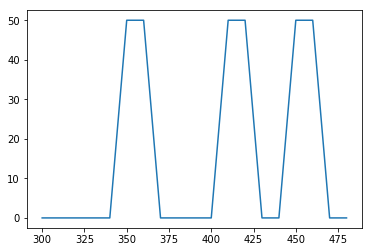

In [153]:
#plot(rate_monitor_excit.t/ms, rate_monitor_excit.smooth_rate(width=25 * ms) / Hz)
#for index4 in range(spike_rates_ts.shape[0]):
#    plot(t_snapshots/ms, spike_rates_ts[index4]/Hz)
plot(t_snapshots/ms, spike_rates_ts[255]/Hz)

In [154]:
sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1]

0.0

Text(0.5,0,u'Time (ms)')

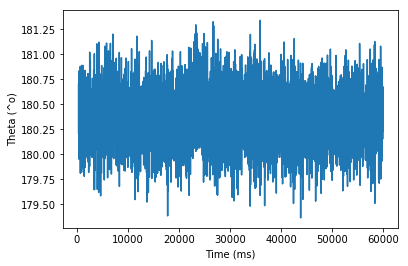

In [14]:
plot(t_snapshots/ms, theta_ts)
ylabel('Theta (^o)')
xlabel('Time (ms)')

In [228]:
e_S_all_inhib, e_S_all_inhib_2

(0.027300689252598733, 0.9078014184397163)

WARNING    /Users/john/Library/Python/2.7/lib/python/site-packages/brian2/units/fundamentalunits.py:209: RuntimeWarning: divide by zero encountered in log10
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


sim_time= 5. s poisson_firing_rate= 5. mHz sigma_weight_profile= 20.0 Jpos_excit2excit= 1.6 t_stimulus_start= 100. ms t_stimulus_duration= 200. ms stimulus_center_deg= 180 stimulus_width_deg= 40 N_excitatory= 128 N_inhibitory= 32 weight_scaling_factor= 16.0 stimulus_strength= 1.5 nA G_inhib2inhib= 100. fS G_inhib2excit= 5. pS G_excit2excit= 110. pS G_excit2inhib= 1.33962449 nS G_extern2excit= 1. nS g_coop= 7. nS monitored_subset_size = 128 synaptic_noise_amount = 0


INFO       width adjusted from 1. ms to 1.05 ms [brian2.monitors.ratemonitor.adjusted_width]


(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125358b10>)

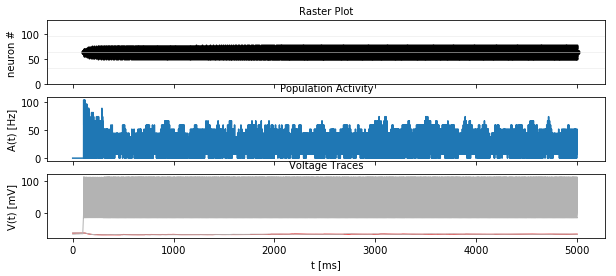

In [4]:
# The one with the EC Layer V neurons
# Run with unstructured Poisson input of higher impulse rate (all neurons receive similar activity)
sim_time_duration    = 500. * ms
t_stimulus_start     = 100*ms
t_stimulus_duration  = 200*ms
stimulus_center_deg  = 180
stimulus_width_deg   = 40
N_excitatory         = 1024
N_inhibitory         = 256
N_excitatory         = 512
N_inhibitory         = 128
#N_excitatory         = 4096
#N_inhibitory         = 1024
N_excitatory         = 2048
N_inhibitory         = 512
weight_scaling_factor= 1.0
sigma_weight_profile = 20.
stimulus_strength    = 0.07 * namp
stimulus_strength    = 0.5 * namp
poisson_firing_rate  = 2.3 * Hz
Jpos_excit2excit     = 1.6

##sigma_weight_profile = 0.34
#weight_scaling_factor= 1.

G_inhib2inhib        = 3. * nS  # 0.3584 * nS #* 0.
G_inhib2inhib        = 0.5*nS #3. * nS  # 0.3584 * nS #* 0.

G_inhib2excit        = 2 * nS  # 0.4676 * nS #* 4.
G_inhib2excit        = 0.5 * nS  # 0.4676 * nS #* 4.

G_excit2excit        = 6. * nS  # 0.13335 * nS# / 2.
G_excit2excit        = 0.5 * nS  # 0.13335 * nS# / 2.

G_excit2inhib        = 12.* nS  # 0.12264 * nS * 98 # = 12nS
G_excit2inhib        = 2.* nS  # 0.12264 * nS * 98 # = 12nS

G_extern2excit       = 24*nS  # = we # 3.1 * nS # was we=6nS


# scipy.optimize.minimize SLSQP
# fitness: 0.6527777777777778: [50.09647318,  163.09337616,  142.89327785, 4039.3909614, 42.08445722] fitness = e_W + e_H
# fitness: 0.6527777777777778: [19107.22914158, 46141.12118672,  8194.23859763, 22931.76914411, 52354.85598259] fitness = e_W + e_H
# fitness: 1.662777777777778: [3.90674420e+01, 6.41396973e+03, 2.40158152e+01, 1.28865870e+00, 2.09827934e+03] fitness = e_W + e_H + e_A, e_A = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
# fitness: 0.2473953940935857 [1.09667969, 1.09667969, 0.99902344, 1.09667969, 1.09667969] fitness = e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: 0.6044482471532799 [1., 1., 1., 1., 1.] (equal to initial values) Does not succeed in finding a solution: 'Positive directional derivative for linesearch' fitness_error = 4*e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: 2.474881805844937 [1., 1., 1., 1., 1.] (equal to initial values) Does not succeed in finding a solution: 'Inequality constraints incompatible' fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2
# Failed even on the simulate_wm with x0 the working parameters. 'Positive directional derivative for linesearch'

# scipy.optimize.minimize TNC
# fitness: 0.19532565528050483: [1., 1., 1., 1., 1.] (equal to initial values) fitness = e_W + e_H + e_A, e_A = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
# fitness: 0.3979377463075265: [1.00000001, 0.99999992, 0.99999998, 0.99999984, 0.99999989] fitness_error = 4*e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: 3.027985852863991 [1., 1., 1., 1., 1.] 'Linear search failed' fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2
# Converged on simulate_wm with x0 the working parameters fitness: 7.045451451040202 [0.3584 , 0.4676 , 0.13335, 0.12264, 3.1] 'Converged (|x_n-x_(n-1)| ~= 0)' Essentially changed only the penultimate parameter rounding it to 0.1226
# Converged on simulate_wm with x0 the working parameters fitness: 7.045451451040202 [0.5    , 0.4676 , 0.13335, 0.12264, 3.1] 'Converged (|x_n-x_(n-1)| ~= 0)' Essentially did not change the altered parameter and kept it to 0.5 

# scipy.optimize.dual_annealing 
# fitness: waiting fitness = e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness:  fitness_error = 4*e_W + e_H + e_A
# fitness:  fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2

# scipy.optimize.basinhopping 
# fitness:  fitness = e_W + e_H + e_A, e_A = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
#    N_excitatory         = 512
#    N_inhibitory         = 128
# fitness: waiting fitness = e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: fitness_error = 4*e_W + e_H + e_A
# fitness:  fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2

stimulus_strength    = 2 * namp
Jpos_excit2excit     = 1.6
#weight_scaling_factor= 1.
# Optimised for 512/128
#G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.86635697,  3.7267002,  66.12077086, 14.73296054,  7.64443366]) * nS
# Optimised for 512/128 scalled for 2048/512
G_inhib2inhib         = 0.21658924 * nS # 0.86635697  / 4.
G_inhib2excit         = 0.93167505 * nS # 3.7267002   / 4.
G_excit2excit         = 16.5301927 * nS # 66.12077086 / 4.
G_excit2inhib         = 3.68324014 * nS # 14.73296054 / 4.
g_coop                = 7.64443366 * nS  # Does not need scaling


# Optimised for 64/16
# N_excitatory         = 64
# N_inhibitory         = 16
# weight_scaling_factor= 4. # Works with original values
# Preference original with scaling 4

# Optimised for 128/32
# N_excitatory         = 128
# N_inhibitory         = 32
# weight_scaling_factor= 4. # Works with original values
# Preference original with scaling 4

# Optimised for 256/64
# N_excitatory         = 256
# N_inhibitory         = 64
# weight_scaling_factor= 2. # Works with original values
# Preference 1 original with scaling 2 (wider bump) or 2 original with scaling 4 (thinner bump and maybe shaking bump borders)

# Optimised for 512/128
# N_excitatory         = 512
# N_inhibitory         = 128
# weight_scaling_factor= 2.
# Preference 1 original with scaling 2 (wider bump) or 2 original with scaling 4 (thinner bump and maybe shaking bump borders)

# Optimised for 1024/256
# N_excitatory         = 1024
# N_inhibitory         = 256
# weight_scaling_factor= 2. # Works with original values
# weight_scaling_factor= 1. # Works with values below
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.35831593,  0.93167505, 16.5301927,   3.68324014,  7.64443366]) * nS # f=3.7811 Both the orgininal with scaling 2.0 and this work but a bit different bump pattern (wider). Both this and the below work equally well.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.35831593,  0.93167505, 16.5301927,   3.68324014, 10.07113891]) * nS # f=3.5296 Both the orgininal with scaling 2.0 and this work but a bit different bump pattern (wider). Both this and the above work equally well.
# Preference 1 original (thinner bump), 2 second, 3 third

# Optimised for 2048/512
# N_excitatory         = 2048
# N_inhibitory         = 512
# weight_scaling_factor= 1.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.23802252,  3.21695086, 53.8695156,   1.97286917, 59.044297]) * nS # Both the orgininal and this work but a bit different bump pattern (wider). Original is better.
# #G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.07514455,  0.93167505, 56.05368036,  3.68324014, 32.23178412]) * nS #  Original is better.
# Preference 1 original (thinner bump), 2 second, 3 third

# # Optimised for 4096/1024
# N_excitatory         = 4096
# N_inhibitory         = 1024
# weight_scaling_factor= 1.
# stimulus_strength    = 8 * namp # Original with scaling 1 and this stimulus is good
# #stimulus_strength    = 2 * namp 
# #G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.1912275,   0.93167505, 25.60881911,  3.68324014, 19.7632547]) * nS  # f=3.6262 Better than original with scaling 1.0. With original no bump is formed. Better than above
# No preference between the original with scaling 1 and stimulus_strength=8*namp or the second with scaling 1 and stimulus_strength=2*namp 

# # Optimised for 8192/2048
# N_excitatory         = 8192
# N_inhibitory         = 2048
# weight_scaling_factor= 1.  # Both scalings work with below values
# weight_scaling_factor= 0.5 # Both scalings work with below values
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.25991654,  0.93167505, 25.60881911,  3.68324014, 29.39697638]) * nS # Same weights as for 4096 works with scaling 1.0. With scaling 0.5 a bit more empty in between the center.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.33958658,  0.93167505, 25.60881911,  3.68324014, 10.9525842]) * nS  # Same weights as for 4096 works with scaling 1.0. With scaling 0.5 too much excitation, no clear bump.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.16387249,  0.86503126, 41.13857958,  3.60112371, 52.21751574]) * nS  # Looks fine with scaling 1.0.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.1912275,   0.93167505, 56.93515254,  6.66132,    19.7632547 ]) * nS  # Looks fine with scaling 1.0.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array() * nS  # 

# Hand tuned solution
N_excitatory         = 2048
N_inhibitory         = 512
weight_scaling_factor= 1. 
poisson_firing_rate  = 2.3 * Hz
G_extern2excit       = 1.0 * nS  # = we # 3.1 * nS # was we=6nS
G_extern2excit       = 3.1 * nS  # = we # 3.1 * nS # was we=6nS
G_extern2inhib       = 2.38* nS
poisson_firing_rate  = 0.001 * Hz
poisson_firing_rate  = 0.005 * Hz
stimulus_strength    = 1.5 * namp 
#G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0001, 0.005, 0.3, 1.0]) * nS
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0001, 0.005, 0.1, 1.0]) * nS # Hand tuned solution
g_coop                = 7.0 * nS  # Does not need scaling

G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.0001, 0.005, 0.1, 1.33962449, 7.0]) * nS # f = 0.11987218039489196 [1]

G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.0, 0.0, 0.0, 0.0, 0.0]) * nS # f = 
G_inhib2excit, G_excit2excit, G_inhib2inhib, G_excit2inhib, g_coop = np.array([0.005, 0.1, 0.0001, 1.33962449, 7.0]) * nS # f = 0.11987218039489196 [1]

G_inhib2excit, G_excit2excit, G_inhib2inhib, G_excit2inhib, G_extern2excit, g_coop = np.array([0.3, 0.3, 0.2, 0.1, 3.1, 7.0]) * nS # f = 

G_inhib2excit, G_excit2excit, G_inhib2inhib, G_excit2inhib, G_extern2excit, g_coop = np.array([0.005, 0.11, 0.0001, 1.33962449, 1.0, 7.0]) * nS # f = 0.11987218039489196 [1]

N_excitatory         = 1024
N_inhibitory         = 256
weight_scaling_factor= 2. # f = 0.141070714925 [1] with factor=2. looks sharper at the edges than the below. Similar with the appearance of [1]
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.00306703636, 0.005, 0.1, 3.17718728, 7.0]) * nS # f = 0.08761707451235637 0.172278606949 Looks more naturally noisy at the edges of the bump than the above
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.0002, 0.01, 0.2, 2.62157557, 7.0]) * nS # f = 0.058279727055005365 0.109737286153 Looks as sharp at the edges as [1] with factor 2.
# Preferred: [1] with factor=2.

N_excitatory         = 512
N_inhibitory         = 128
weight_scaling_factor= 4. # f = 0.560718023616 Even though the fitness value is larger than [2] below the bump looks much straighter than [2].
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.000111035454, 0.02, 0.4, 4.0, 6.76433372]) * nS # f = 0.06124218533489588 0.0822180857573 [2] Bump width thinner than [1] with factor=4.
# Preferred: [1] with factor=4. looks like more precise and thinner bump, [2] has smaller fitness value. The difference in fitness value is due to the [1] with factor=4. producing a thinner bump width than the desired specification so the fitness value does not matter. 

N_excitatory         = 256
N_inhibitory         = 64
# stimulus_strength    = 1.5 * namp 
# weight_scaling_factor= 4. # f = 0.282864341828 0.0141963115662 with [1] The bump borders are fuzy but width seems more constant than [2] and [3]/
# weight_scaling_factor= 6. # bump stops at 2.5s
weight_scaling_factor= 8. # no bump
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.000618624974, 0.04, 0.8, 8.0, 9.58639314]) * nS # f = 0.14743962094831045 0.128322818647 0.0128131947813 [2] Bump width thinner than [1] with factor=4. Bump seems to be increasing in width a bit.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.00263306594,  0.04, 0.8, 8.0, 9.18333471]) * nS # f = 0.09385390195304502 0.128108982487 0.127049339034 [3] Bump seems to be increasing in width a bit.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.00159845390, 0.0666432083, 0.826643199, 2.09866259, 7.0]) * nS # f = 0.055548008504473875 0.0695892047013 0.0612895539476 [7] Bump thicker than [2] [3] [4] [5]. but is theta equally stable with [1]? 
# Preferred: [2] or [3] or [7] Bump width closer to desired and bump heading more stable. [4] Values closer to [1] with factor 8. but is theta equally stable?

#### [1] fitness_error=0.288051635108  e_W_all=0.0141963115662  e_H_all=0.00199211845119  e_A_all=0.00878787310986  e_W_2=0.036712565009  e_H_2=0.0045153536749  e_A_2=0.00662251655629  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=0.0115893904402 65deg
# [2] fitness_error=0.120968395254  e_W_all=0.0128131947813  e_H_all=0.0019323996391  e_A_all=0.00787322264936  e_W_2=0.00522537648289  e_H_2=0.00234359560342  e_A_2=0.00662251655629  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=0.0120038044854 55deg
# [3] fitness_error=0.127049339034  e_W_all=0.0126955890908  e_H_all=0.00198150922758  e_A_all=0.00800081884713  e_W_2=0.00653250132533  e_H_2=0.00189608764746  e_A_2=0.00662251655629  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=0.0124079546753 55deg
# [7] fitness_error=0.0612895539476  e_W_all=0.0073469090857  e_H_all=0.00194913619332  e_A_all=0.00894713748832  e_W_2=0.000833609288891  e_H_2=0.00268449919113  e_A_2=0.00662251655629  %e_W_all_inhib=0.995835554371  e_S_all_inhib_2=0.0  W_diff=0.000183672645624 ~55deg    

N_excitatory         = 128
N_inhibitory         = 32
weight_scaling_factor= 16. # f = 

# N_excitatory         = 4096
# N_inhibitory         = 1024
# weight_scaling_factor= 0.5 # f = 0.301673916296 65deg

# N_excitatory         = 8192
# N_inhibitory         = 2048
# weight_scaling_factor= 0.25 # f = 0.338114983743 67deg

# For the current tested case 
sim_time_duration    = 5000. * ms

synaptic_noise_amount = 0
monitored_subset_size = N_excitatory

# Normal model
#print('sim_time=',sim_time_duration, 'poisson_firing_rate=',poisson_firing_rate, 'sigma_weight_profile=',sigma_weight_profile, 'Jpos_excit2excit=',Jpos_excit2excit, 't_stimulus_start=',t_stimulus_start, 't_stimulus_duration=',t_stimulus_duration, 'stimulus_center_deg=',stimulus_center_deg,'stimulus_width_deg=',stimulus_width_deg,'N_excitatory=',N_excitatory,'N_inhibitory=',N_inhibitory,'weight_scaling_factor=',weight_scaling_factor,'stimulus_strength=',stimulus_strength, 'G_inhib2inhib=',G_inhib2inhib, 'G_inhib2excit=',G_inhib2excit, 'G_excit2excit=',G_excit2excit, 'G_excit2inhib=',G_excit2inhib, 'G_extern2excit=',G_extern2excit, 'g_coop=',g_coop)
print('sim_time=',sim_time_duration, 'poisson_firing_rate=',poisson_firing_rate, 'sigma_weight_profile=',sigma_weight_profile, 'Jpos_excit2excit=',Jpos_excit2excit, 't_stimulus_start=',t_stimulus_start, 't_stimulus_duration=',t_stimulus_duration, 'stimulus_center_deg=',stimulus_center_deg,'stimulus_width_deg=',stimulus_width_deg,'N_excitatory=',N_excitatory,'N_inhibitory=',N_inhibitory,'weight_scaling_factor=',weight_scaling_factor,'stimulus_strength=',stimulus_strength, 'G_inhib2inhib=',G_inhib2inhib, 'G_inhib2excit=',G_inhib2excit, 'G_excit2excit=',G_excit2excit, 'G_excit2inhib=',G_excit2inhib, 'G_extern2excit=',G_extern2excit, 'g_coop=',g_coop, 'monitored_subset_size =', monitored_subset_size, 'synaptic_noise_amount =', synaptic_noise_amount)
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_EC_LV_Principal_Neurons_1(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit, G_extern2inhib=G_extern2inhib, g_coop=g_coop, monitored_subset_size = monitored_subset_size, synaptic_noise_amount = synaptic_noise_amount)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)


Text(0.5,0,u'Time (ms)')

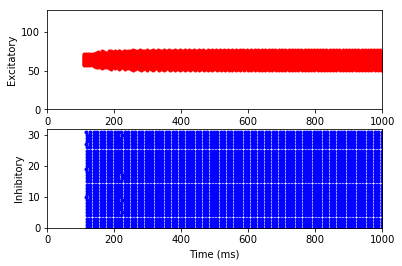

In [50]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
xlim([0,sim_time_duration/ms])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
xlim([0,sim_time_duration/ms])
ylabel('Inhibitory')
xlabel('Time (ms)')

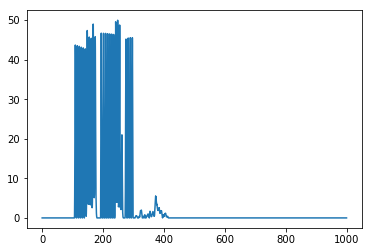

In [11]:
plot(rate_monitor_excit.t/ms, rate_monitor_excit.smooth_rate(width=1 * ms) / Hz)

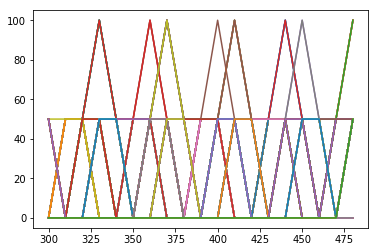

In [226]:
# Calculate profile of excitatory neurons
(t_snapshots, spike_rates_ts) = calcSpikeRates(
    spike_monitor_excit, N_excitatory, 
    #spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)
for index1 in range(len(spike_rates_ts)): 
    if count_nonzero(spike_rates_ts[index1]/Hz) > 0:
        #print(index1)
        plot(t_snapshots/ms, spike_rates_ts[index1]/Hz)

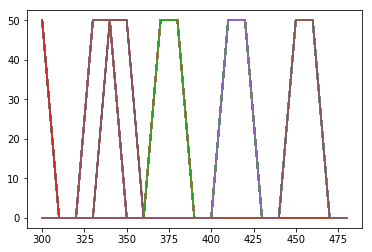

In [227]:
# Calculate profile of inhibitory neurons
(t_snapshots_inhib, spike_rates_ts_inhib) = calcSpikeRates(
    #spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)
for index1 in range(len(spike_rates_ts_inhib)): 
    if count_nonzero(spike_rates_ts_inhib[index1]/Hz) > 0:
        plot(t_snapshots_inhib/ms, spike_rates_ts_inhib[index1]/Hz)

(-10, 20)

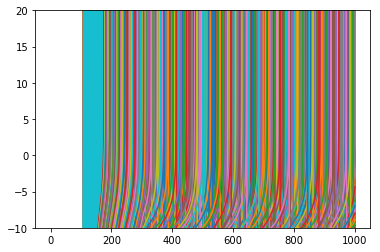

In [102]:
for index2 in range(len(voltage_monitor_excit.v)):
    plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[index2]/mV)
#ylim([-10,20])

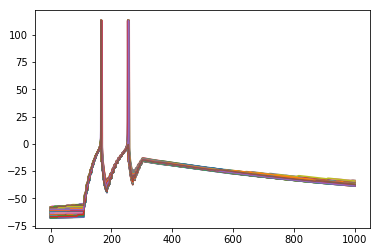

In [23]:
for index2 in range(len(voltage_monitor_inhib.v)):
    plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[index2]/mV)
#ylim([-40,20])

In [24]:
#for index3 in range(0, len(voltage_monitor_excit.O_coop), 10):
#    plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.O_coop[index3])
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.O_coop[255]) # 214-298 100 until the end. Down to 207 and Up to 302 interminent

AttributeError: No attribute with name O_coop

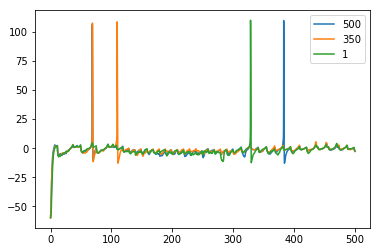

In [34]:
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[500]/mV, label='500')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[350]/mV, label='350')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[1]/mV, label='1')
legend()
#ylim([-0.030, 0.01])

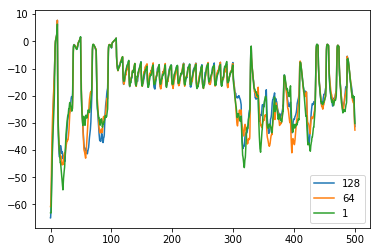

In [35]:
plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[127]/mV, label='128')
plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[64]/mV, label='64')
plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[1]/mV, label='1')
legend()

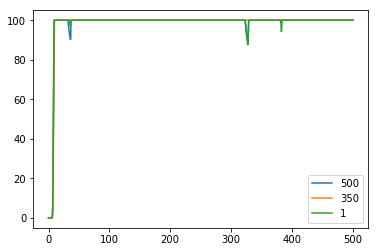

In [36]:
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit[500].O_coop, label='500')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit[350].O_coop, label='350')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit[1].O_coop, label='1')
legend()

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127f26390>)

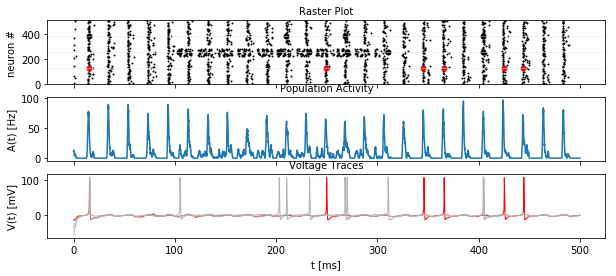

In [59]:
# Reduced model so mAChR is replaced with AMPA
weight_scaling_factor= 1.
stimulus_strength = 0.5*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([10.89212943,  7.20597675,  8.09613807,  8.09613807, 48.7]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_EC_LV_Principal_Neurons_reduced(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

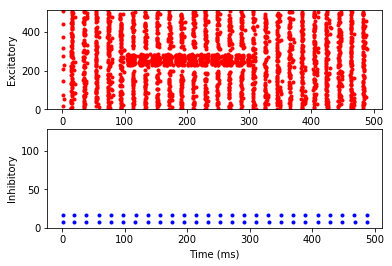

In [60]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13573a1d0>)

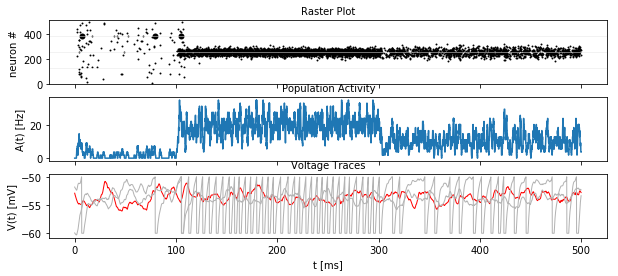

In [119]:
# Run the original simulate_wm with NMDA receptors/channels with default parameter values
weight_scaling_factor= 4.
stimulus_strength = 0.5*namp
#rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib)
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1295e3190>)

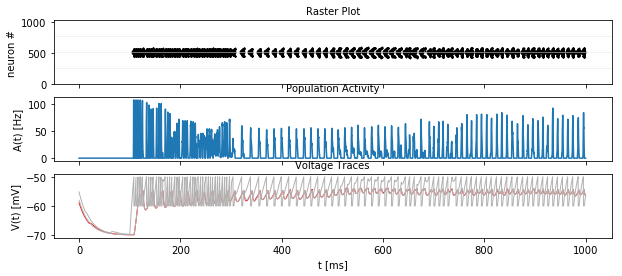

In [7]:
stimulus_center_deg   = 180
stimulus_width_deg    = 40
stimulus_strength     = 2.0 * namp # 0.5 * namp,
t_stimulus_start      = 100 * ms
t_stimulus_duration   = 200 * ms
available_RAM         = 32e9
N_excitatory          = 1024
N_inhibitory          = 256
weight_scaling_factor = 2.0
sigma_weight_profile = 20. 
sim_time_duration     = 1000. * ms
t_window_width      = 200*ms
snapshot_interval   = 100*ms
synaptic_noise_amount = 0.0
poisson_firing_rate   = 0.005 * Hz

G_inhib2inhib         = .35 * 1.024 * nS # 0.86635697  / 4.
G_inhib2excit         = .35 * 1.336 * nS # 3.7267002   / 4.
G_excit2excit         = .35 * 0.381 * nS # 66.12077086 / 4.
G_excit2inhib         = .35 * 1.2 * 0.292 * nS # 14.73296054 / 4.
G_extern2inhib        = 2.38 * nS
G_extern2excit        = 3.1 * nS
Jpos_excit2excit      = 1.6
stimulus_strength     = 1.5 * namp

monitored_subset_size = N_excitatory

# Run the original simulate_wm with NMDA receptors/channels with default parameter values
#rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib)
#rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength)
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit, monitored_subset_size = monitored_subset_size, synaptic_noise_amount = synaptic_noise_amount)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e22cb50>)

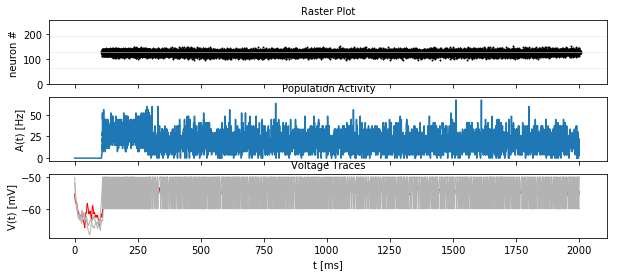

In [20]:
tau_excit=10*ms # 0.5-100 can establish bump
tau_inhib=tau_excit/2
poisson_firing_rate   = 0.5 * Hz # 1.4 * Hz # 0.6 <= 1.4 <=1.6

# Minimum noise required for a functioning bump attractor function
# tau_excit poisson_firing_rate (256)                poisson_firing_rate (512)
#  0.5*ms                                                  0.01 * Hz / 0.15 * Hz
#    1*ms      0.5 * Hz / 0.2 * Hz                         0.005 * Hz / 0.15 * Hz
#    2*ms      0.005 * Hz
#   10*ms      0.005 * Hz                                   0.005 * Hz / 0.15 * Hz
#   30*ms      0.005 * Hz
#   40*ms      0.005 * Hz 0.05 * Hz (solid firing)          0.005 * Hz
#   50*ms      0.05 * Hz                                    0.01 * Hz 0.05 * Hz (solid firing)
#   60*ms      0.05 * Hz                                    0.05 * Hz / 0.15 * Hz
#   70*ms      0.05 * Hz                                    0.05 * Hz
#   80*ms      0.1 * Hz                                     0.1 * Hz
#   90*ms      0.2 * Hz                                     0.15 * Hz
#  100*ms      0.2 * Hz                                     0.15 * Hz


N_excitatory          = 256 # 256 512
N_inhibitory          = 64 # 64 128
weight_scaling_factor = 8. #  4.
stimulus_strength     = 0.5*namp
sim_time_duration     = 2000. * ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, tau_excit=tau_excit, tau_inhib=tau_inhib)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b23f450>)

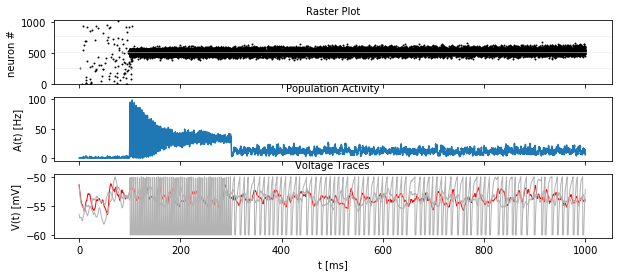

In [36]:
from neurodynex.working_memory_network import wm_model_modified

stimulus_center_deg   = 180
stimulus_width_deg    = 40
#stimulus_strength     = 2.0 * namp # 0.5 * namp,
t_stimulus_start      = 100 * ms
t_stimulus_duration   = 200 * ms
available_RAM         = 32e9
N_excitatory          = 1024
N_inhibitory          = 256
weight_scaling_factor = 2.0
sigma_weight_profile  = 20. 
sim_time_duration     = 1000. * ms
t_window_width        = 200*ms
snapshot_interval     = 100*ms
synaptic_noise_amount = 0.0
poisson_firing_rate   = 0.5*Hz # 0.005 * Hz

G_inhib2inhib         = .35 * 1.024 * nS # 0.86635697  / 4.
G_inhib2excit         = .35 * 1.336 * nS # 3.7267002   / 4.
G_excit2excit         = .35 * 0.381 * nS # 66.12077086 / 4.
G_excit2inhib         = .35 * 1.2 * 0.292 * nS # 14.73296054 / 4.
G_extern2inhib        = 2.38 * nS
G_extern2excit        = 3.1 * nS
Jpos_excit2excit      = 1.6
stimulus_strength     = 2.0 * namp # 1.5 * namp
monitored_subset_size = N_excitatory
J_inhib2inhib         = 0.3 / 1000
J_inhib2excit         = 0.3 / 1000
J_excit2inhib         = 0.3 / 1000
J_ext2inhib           = 1.0
J_ext2excit           = 1.0
tau_excit             = 20.0*ms # Default is 20.0 * ms,
tau_inhib             = 10.0*ms  # Default is 10.0 * ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm(N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount = synaptic_noise_amount, monitored_subset_size = monitored_subset_size)

#rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm_skewed(N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount = synaptic_noise_amount, monitored_subset_size = monitored_subset_size)

plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12feda250>)

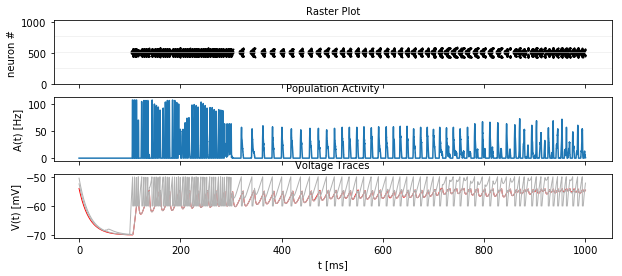

In [41]:
tau_excit             = 100*ms # Default is 20.0 * ms,
tau_inhib             = tau_excit/2  # Default is 10.0 * ms
poisson_firing_rate   = 0.005*Hz
#rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm(N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount = synaptic_noise_amount, monitored_subset_size = monitored_subset_size, tau_excit=tau_excit, tau_inhib=tau_inhib)
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm_tau(N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount = synaptic_noise_amount, monitored_subset_size = monitored_subset_size, tau_excit=tau_excit, tau_inhib=tau_inhib, poisson_firing_rate=poisson_firing_rate)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x132fe5650>)

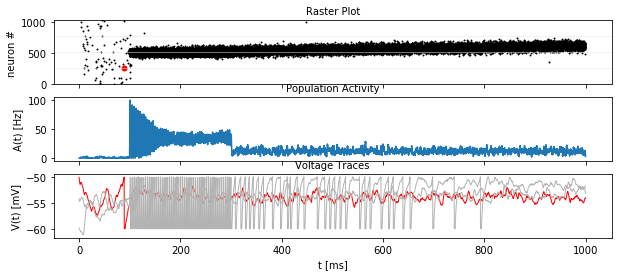

In [11]:
weights_skewness = 0.1 # From 0.05 upwards the systematic drift is visible
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model_modified.simulate_wm_skewed(N_excitatory=N_excitatory, N_inhibitory=N_inhibitory, weight_scaling_factor=weight_scaling_factor, stimulus_center_deg=stimulus_center_deg, stimulus_width_deg=stimulus_width_deg, stimulus_strength=stimulus_strength, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, sim_time=sim_time_duration, synaptic_noise_amount = synaptic_noise_amount, monitored_subset_size = monitored_subset_size, weights_skewness = weights_skewness)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

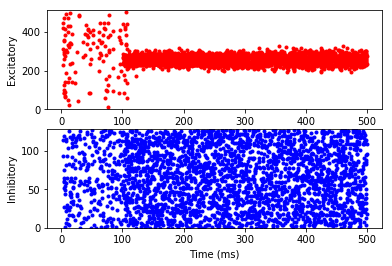

In [120]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d1ebb50>)

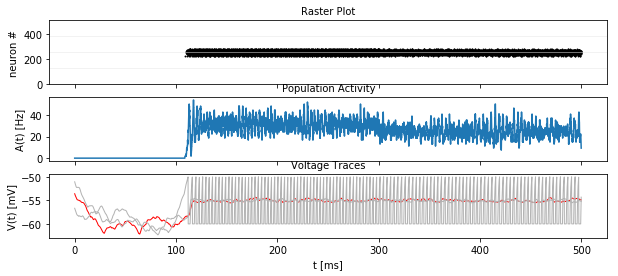

In [80]:
# Run simulate_wm with non default synaptic conductances
weight_scaling_factor= 1.
stimulus_strength = 0.5*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([4.11196681, 4.11196681, 3.20004824, 4.11196681, 1.92852664]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)

plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

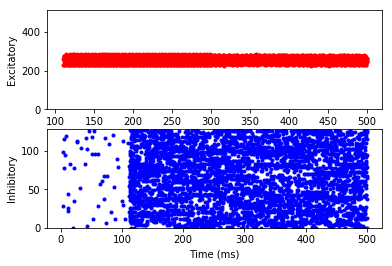

In [81]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13161e410>)

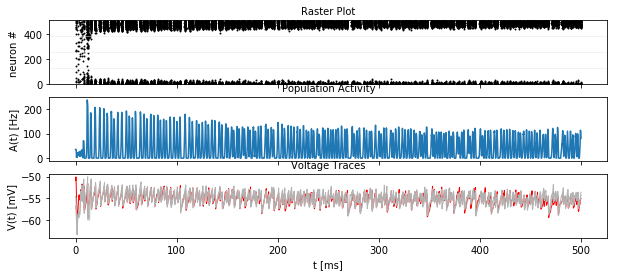

In [52]:
# Run simulate_wm_reduced Reduced model using AMPA channels only
weight_scaling_factor= 1.
stimulus_strength = 0.5*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([ 2.09711082, 31.45849158, 17.95217943, 30.91330191, 45.0980548 ]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_reduced(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

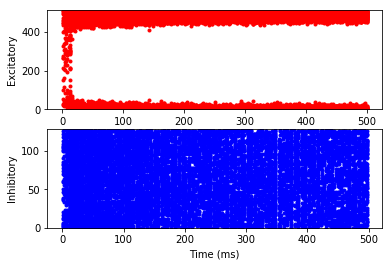

In [53]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123322fd0>)

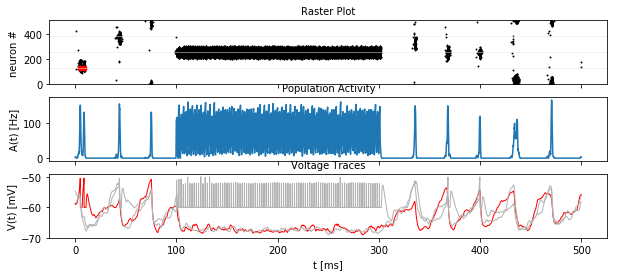

In [15]:
# Run simulate_wm_reduced2 Reduced model using AMPA channels only
weight_scaling_factor= 1.
stimulus_strength = 20.*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([30.68446107, 22.10526499, 21.85452222, 15.62642328,  3.86240685]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_reduced2(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

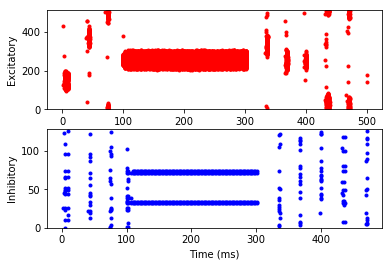

In [16]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')